In [55]:
"""
D-FactNET for KdV Equation
u_t + eta*u*u_x + mu^2*u_xxx = 0, eta=1, mu=0.022
Periodic BC
"""

import jax
from jax import random, vmap, grad, jit
from functools import partial
import jax.numpy as jnp
import numpy as np
import optax
import flax.linen as nn
from torch.utils import data
from flax.training import checkpoints
import scipy.io
import os
import itertools
from tqdm import trange
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)


class MLP(nn.Module):
    num_layers: int = 4
    hidden_dim: int = 512
    output_dim: int = 9
    activation: callable = nn.tanh

    @nn.compact
    def __call__(self, x):
        for _ in range(self.num_layers):
            x = nn.Dense(self.hidden_dim)(x)
            x = self.activation(x)
        x = nn.Dense(self.output_dim)(x)
        return x


def y_true(U, dx, dt, eta=1.0, mu=0.022):
    u0, u1, u2, u3, u4 = U[0], U[1], U[2], U[3], U[4]
    advection = eta * u2 * (u3 - u1) / (2*dx)
    dispersion = mu**2 * (u4 - 2*u3 + 2*u1 - u0) / (2*dx**3)
    return u2 + dt * (-advection - dispersion)


class data_gen(data.Dataset):
    def __init__(self, dx, dt, batch_size, eta=1.0, mu=0.022, rng_key=random.PRNGKey(0)):
        self.dx = dx
        self.dt = dt
        self.eta = eta
        self.mu = mu
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def generate_data(self, key):
        u_data = random.uniform(key, (self.batch_size, 5), minval=-1.0, maxval=2.50)
        y_data = vmap(lambda u: y_true(u, self.dx, self.dt, self.eta, self.mu))(u_data)
        y_data = y_data.reshape(-1, 1)
        
        u1, u2, u3 = u_data[:, 1:2], u_data[:, 2:3], u_data[:, 3:4]
        u2_u3 = u3*u2
        u1_u2 = u2 *u1
        ones = jnp.ones((self.batch_size, 1))
        
        # [u0, u1, u2, u3, u4, u1*u2, u2*u3, y, 1] -> (9, batch)
        data_batch = jnp.concatenate([u_data, u1_u2, u2_u3, y_data, ones], axis=1).T
        input_dummy = jnp.array([[1.0, 1.0, 1.0]])
        
        return input_dummy, data_batch
    
    def __getitem__(self, index):
        self.key, epoch_key = random.split(self.key)
        return self.generate_data(epoch_key)


class MLPFactorizer():
    def __init__(self, arch, batch=None, rng_key=random.PRNGKey(1), skip_init=False):
        self.input_dummy = jnp.array([[1.0, 1.0, 1.0]])
        self.model = arch
        if not skip_init:
            if batch is None:
                raise ValueError("Batch is needed for training")
            self.params = self.model.init(rng_key, self.input_dummy)
            print(self.model.tabulate(rng_key, self.input_dummy))
        else:
            self.params = None
        
        lr = optax.exponential_decay(1e-3, transition_steps=1000, decay_rate=0.9)
        self.optimizer = optax.adam(learning_rate=lr)
        self.opt_state = self.optimizer.init(self.params) if self.params is not None else None
        self.loss_log = []

    def loss(self, params, batch):
        _, data_batch = batch
        coeff = self.model.apply(params, self.input_dummy)
        coeff = coeff.reshape(1, 9)

        g_matrix = coeff @ data_batch
        loss = jnp.mean(g_matrix**2)

        coeff_magnitude_sq_term = jnp.sum(coeff**2, axis=0)
        penalty_per_term = jnp.maximum(0, 1e-10 - coeff_magnitude_sq_term)
        penalty = 0.5 * jnp.sum(penalty_per_term)

        H = coeff[0, 7]  # coefficient for y
        scale_penalty = (jnp.abs(H) - 1)**2

        return loss + 5*penalty + 5*scale_penalty 
    
    @partial(jit, static_argnums=(0,))
    def step(self, params, opt_state, batch):
        grads = grad(self.loss)(params, batch)
        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    def train(self, dataset, nIter=10000):
        data_iter = iter(dataset)
        pbar = trange(nIter)
        self.final_step = nIter
        for it in pbar:
            batch = next(data_iter)
            self.params, self.opt_state = self.step(self.params, self.opt_state, batch)
            if it % 1000 == 0:
                loss = self.loss(self.params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'loss': loss})

    def coeff_finder(self):
        return self.model.apply(self.params, self.input_dummy).reshape(1, 9)
    
    def save_model(self, ckpt_dir='checkpoints'):
        ckpt_dir = os.path.abspath(ckpt_dir)
        os.makedirs(ckpt_dir, exist_ok=True)
        checkpoint_data = {'params': self.params, 'coefficients': self.coeff_finder()}
        checkpoints.save_checkpoint(ckpt_dir=ckpt_dir, target=checkpoint_data, step=self.final_step, overwrite=True)
        print(f"Model saved to {ckpt_dir}")
    
    def load_model(self, ckpt_dir='checkpoints'):
        checkpoint_data = {'params': self.params if self.params is not None else {}, 'coefficients': jnp.zeros((1, 9))}
        restored = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=checkpoint_data, step=None)
        self.params = restored['params']
        print(f"Model loaded from {ckpt_dir}")
        return restored['coefficients']


def solve_dfactnet(learned_coeff, u0, x_star, approx_dx=0.1, approx_dt=1e-2):
    """Periodic BC using jnp.roll, no clipping."""
    approx_x = jnp.arange(-1.0, 1.0, approx_dx)
    approx_t = jnp.arange(0, 1, approx_dt)
    approx_U0 = jnp.interp(approx_x, x_star, u0)

    A, B, C, D, E, F, G, H, I = [learned_coeff[0, i] for i in range(9)]

    def time_step(u, _):
        u0_vals = jnp.roll(u, 2)
        u1_vals = jnp.roll(u, 1)
        u2_vals = u
        u3_vals = jnp.roll(u, -1)
        u4_vals = jnp.roll(u, -2)
        u2_u1 = u2_vals * u1_vals
        u2_u3 = u2_vals * u3_vals
        y = -(A*u0_vals + B*u1_vals + C*u2_vals + D*u3_vals + E*u4_vals + F*(u2_u1) + G*(u2_u3) + I) / H
        y = y
        y = jnp.clip(y, -1.0, 1.0)
        #y = jnp.round(y, decimals=2)
        return y, y

    _, U = jax.lax.scan(time_step, approx_U0, None, length=len(approx_t) - 1)
    U_approx = jnp.vstack([approx_U0, U])
    U_approx = U_approx
    return approx_t, approx_x, U_approx


def interpolate_to_ref_grid(u_approx, t_approx, x_approx, t_ref, x_ref):
    from scipy.interpolate import RegularGridInterpolator
    interp = RegularGridInterpolator((np.array(t_approx), np.array(x_approx)), np.array(u_approx), method='linear', bounds_error=False, fill_value=None)
    TT, XX = np.meshgrid(t_ref, x_ref, indexing='ij')
    return jnp.array(interp(np.stack([TT.flatten(), XX.flatten()], axis=-1)).reshape(len(t_ref), len(x_ref)))


def compute_errors(u_approx, u_ref):
    return {
        'l2_relative': float(jnp.linalg.norm(u_approx - u_ref) / jnp.linalg.norm(u_ref)),
        'l_inf': float(jnp.max(jnp.abs(u_approx - u_ref))),
        'mse': float(jnp.mean((u_approx - u_ref) ** 2)),
        'mae': float(jnp.mean(jnp.abs(u_approx - u_ref))),
    }


def plot_comparison(u_ref, u_approx, t_star, x_star, save_prefix='dfactnet_kdv'):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    vmin, vmax = u_ref.min(), u_ref.max()
    im0 = axes[0].pcolormesh(t_star, x_star, u_ref.T, cmap='jet', shading='auto', vmin=vmin, vmax=vmax)
    axes[0].set_xlabel('t'); axes[0].set_ylabel('x'); axes[0].set_title('Reference'); plt.colorbar(im0, ax=axes[0])
    im1 = axes[1].pcolormesh(t_star, x_star, u_approx.T, cmap='jet', shading='auto', vmin=vmin, vmax=vmax)
    axes[1].set_xlabel('t'); axes[1].set_ylabel('x'); axes[1].set_title('D-FactNET'); plt.colorbar(im1, ax=axes[1])
    im2 = axes[2].pcolormesh(t_star, x_star, jnp.abs(u_ref - u_approx).T, cmap='hot', shading='auto')
    axes[2].set_xlabel('t'); axes[2].set_ylabel('x'); axes[2].set_title('Absolute Error'); plt.colorbar(im2, ax=axes[2])
    plt.tight_layout(); plt.savefig(f'{save_prefix}_comparison.png', dpi=150); plt.show()


def plot_slices(u_ref, u_approx, t_star, x_star, time_slices=[0.0, 0.2, 0.5, 0.75, 1.0], save_prefix='dfactnet_kdv'):
    fig, axes = plt.subplots(1, len(time_slices), figsize=(4 * len(time_slices), 4))
    for ax, t_val in zip(axes, time_slices):
        t_idx = int(t_val * (len(t_star) - 1))
        ax.plot(x_star, u_ref[t_idx, :], 'b-', lw=2, label='Reference')
        ax.plot(x_star, u_approx[t_idx, :], 'r--', lw=2, label='D-FactNET')
        ax.set_xlabel('x'); ax.set_ylabel('u')
        ax.set_title(f't = {t_star[t_idx]:.2f}')
        ax.legend(); ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(f'{save_prefix}_slices.png', dpi=150); plt.show()



print("JAX devices:", jax.devices())
dx, dt, eta, mu, batch_size, nIter = 0.1, 1e-2, 1.0, 0.022, 2048, 150000

dataset = data_gen(dx, dt, batch_size, eta=eta, mu=mu)
mlp_arch = MLP(num_layers=8, hidden_dim=512, output_dim=9, activation=nn.tanh)
factorizer = MLPFactorizer(mlp_arch, batch=dataset)
factorizer.train(dataset, nIter=nIter)

learned_coeff = factorizer.coeff_finder()
print("Learned coefficients [A, B, C, D, E, F, G, H, I]:", learned_coeff)
factorizer.save_model('kdv_checkpoint')



JAX devices: [CudaDevice(id=0)]

                                  MLP Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs         ┃ outputs        ┃ params                  ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float64[1,3]   │ float64[1,9]   │                         │
├─────────┼────────┼────────────────┼────────────────┼─────────────────────────┤
│ Dense_0 │ Dense  │ float64[1,3]   │ float64[1,512] │ bias: float32[512]      │
│         │        │                │                │ kernel: float32[3,512]  │
│         │        │                │                │                         │
│         │        │                │                │ 2,048 (8.2 KB)          │
├─────────┼────────┼────────────────┼────────────────┼─────────────────────────┤
│ Dense_1 │ Dense  │ float64[1,512] │ float64[1,512] │ bias: float32[512]   

100%|██████████| 150000/150000 [01:59<00:00, 1251.22it/s, loss=2.3366287784947974e-11]


Learned coefficients [A, B, C, D, E, F, G, H, I]: [[ 2.41832251e-03 -4.84262163e-03  9.99996453e-01  4.83739428e-03
  -2.42167956e-03  5.00012419e-02 -4.99987496e-02 -9.99999997e-01
   1.00023622e-05]]
Model saved to /home/madheshmd/grad/Assigments/pinns_hybrid/kdv_checkpoint


L2 Error: 8.3869e-01


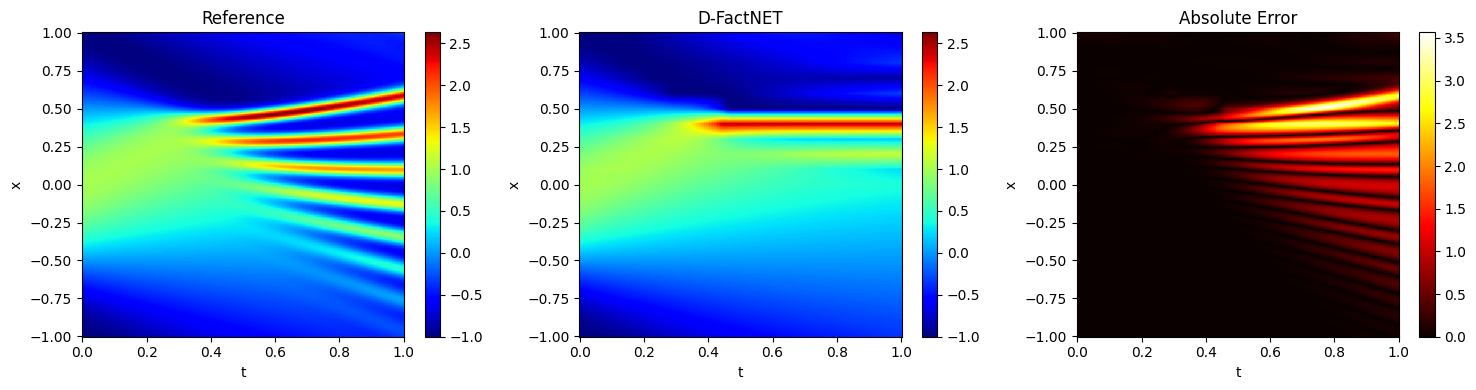

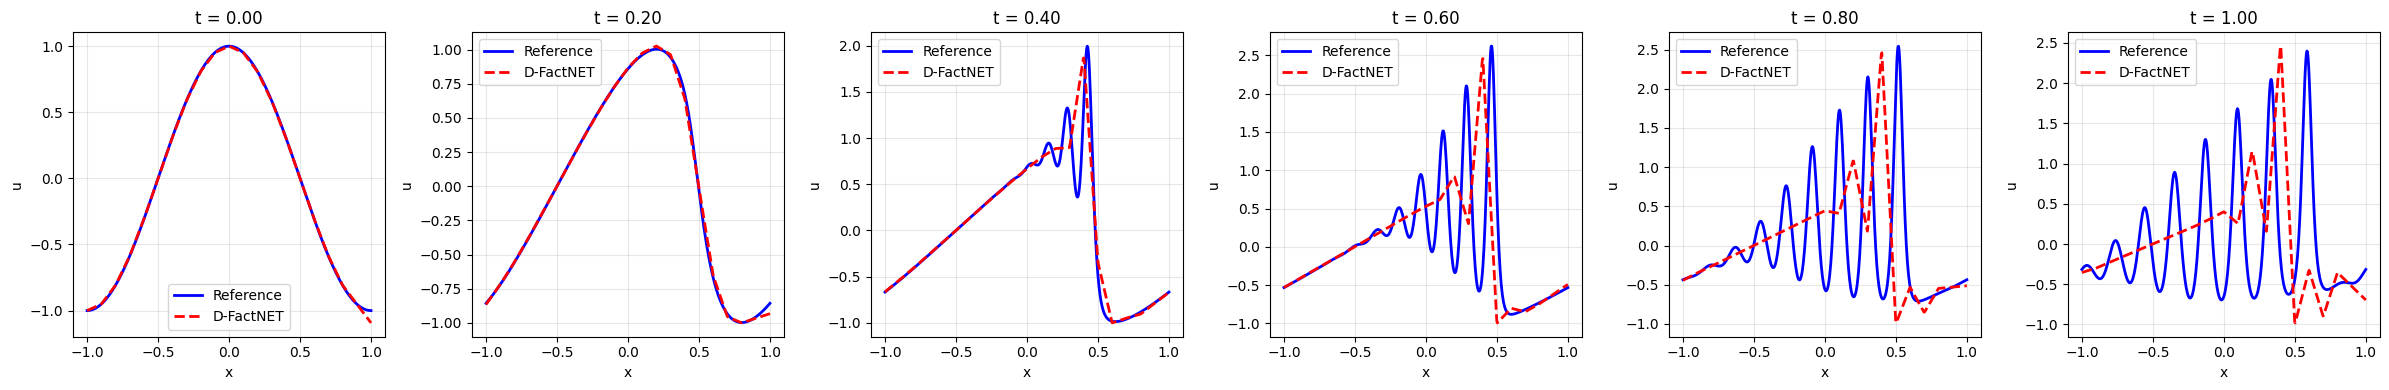

In [56]:
def solve_dfactnet(learned_coeff, u0, x_star, approx_dx=0.1, approx_dt=1e-2):
    """Periodic BC using jnp.roll, no clipping."""
    approx_x = jnp.arange(-1.0, 1.0, approx_dx)
    approx_t = jnp.arange(0, 1, approx_dt)
    approx_U0 = jnp.interp(approx_x, x_star, u0)

    A, B, C, D, E, F, G, H, I = [learned_coeff[0, i] for i in range(9)]

    def time_step(u, _):
        u0_vals = jnp.roll(u, 2)
        u1_vals = jnp.roll(u, 1)
        u2_vals = u
        u3_vals = jnp.roll(u, -1)
        u4_vals = jnp.roll(u, -2)
        u2_u1 = u2_vals * u1_vals
        u2_u3 = u2_vals * u3_vals
        y = -(A*u0_vals + B*u1_vals + C*u2_vals + D*u3_vals + E*u4_vals + F*(u2_u1) + G*(u2_u3) + I) / H
        y = jnp.clip(y, -1.0, 2.5)
        #y = jnp.round(y, decimals=4)
        return y, y

    _, U = jax.lax.scan(time_step, approx_U0, None, length=len(approx_t) - 1)
    U_approx = jnp.vstack([approx_U0, U])
    U_approx = U_approx
    return approx_t, approx_x, U_approx

def plot_slices(u_ref, u_approx, t_star, x_star, time_slices=[0.0, 0.2,0.4,0.6,0.8, 1.0], save_prefix='dfactnet_kdv'):
    fig, axes = plt.subplots(1, len(time_slices), figsize=(4 * len(time_slices), 4))
    for ax, t_val in zip(axes, time_slices):
        t_idx = int(t_val * (len(t_star) - 1))
        ax.plot(x_star, u_ref[t_idx, :], 'b-', lw=2, label='Reference')
        ax.plot(x_star, u_approx[t_idx, :], 'r--', lw=2, label='D-FactNET')
        ax.set_xlabel('x'); ax.set_ylabel('u')
        ax.set_title(f't = {t_star[t_idx]:.2f}')
        ax.legend(); ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(f'{save_prefix}_slices.png', dpi=150); plt.show()

data_mat = scipy.io.loadmat('kdv.mat')
u_ref, t_star, x_star = data_mat['usol'], data_mat['t'].flatten(), data_mat['x'].flatten()
approx_t, approx_x, U_approx = solve_dfactnet(learned_coeff, u_ref[0, :], x_star)
u_approx_interp = interpolate_to_ref_grid(U_approx, approx_t, approx_x, t_star, x_star)
errors = compute_errors(u_approx_interp, u_ref)
print(f"L2 Error: {errors['l2_relative']:.4e}")
plot_comparison(u_ref, u_approx_interp, t_star, x_star)
plot_slices(u_ref, u_approx_interp, t_star, x_star)